In [1]:
# Setup scenario
from copy import deepcopy
import json
from pathlib import Path

from constants import DATA_ENTITIES_DIR, DATA_HAZARDS_DIR, DATA_TEMP_DIR, REQUIREMENTS_DIR
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from climada.engine import CostBenefit, Impact, ImpactCalc
from climada.engine.cost_benefit import risk_aai_agg
from climada.entity import DiscRates, Entity, Exposures, LitPop
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet, ImpfTropCyclone
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
from climada.entity.measures import Measure, MeasureSet
from climada.hazard import Hazard
from climada.util.api_client import Client

from costben.costben_handler import CostBenefitHandler
from entity.entity_handler import EntityHandler
from exposure.exposure_handler import ExposureHandler
from hazard.hazard_handler import HazardHandler
from impact.impact_handler import ImpactHandler

import handlers
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])

costben_handler = CostBenefitHandler()
entity_handler = EntityHandler()
exposure_handler = ExposureHandler()
hazard_handler = HazardHandler()
impact_handler = ImpactHandler()


# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', flood, 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"  # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "river_flood"  # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
scenario = "rcp26"  # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
time_horizon = "2030_2050"  # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']
annual_growth = 1.01

client = Client()

In [14]:
future_year = 2050
hazard_present = Hazard.from_mat(DATA_HAZARDS_DIR / "hazard_drought_THA_historical.mat")
hazard_present.check()
hazard_future = Hazard.from_mat(DATA_HAZARDS_DIR / "hazard_drought_THA_rcp45.mat")
hazard_future.check()

# hazard_present.intensity.min()  # -0.9187603885272276 -4
# hazard_future.intensity.min()  # -4

# hazard_present.intensity_thres = -4
# hazard_future.intensity_thres = -4

# hazard_present.plot_rp_intensity(return_periods=(25,), smooth=False)
# hazard_future.plot_rp_intensity(return_periods=(25,), smooth=False)

entity_present = Entity.from_excel(DATA_ENTITIES_DIR / "entity_TODAY_THA_flood_roads.xlsx")
entity_present.check()

# exposure_present = Exposures(pd.read_excel(DATA_ENTITIES_DIR / "entity_TODAY_THA_drought_wet_markets.xlsx"))
exposure_present = entity_present.exposures
exposure_present.check()
exposure_present.ref_year = 2024

exposure_future = deepcopy(exposure_present)
exposure_future.ref_year = future_year
n_years = exposure_future.ref_year - exposure_present.ref_year + 1
growth_rate = 1.0294
growth = growth_rate ** n_years
exposure_future.gdf['value'] = exposure_future.gdf['value'] * growth
exposure_future.check()

# exposure_present.plot_scatter()
# exposure_future.plot_scatter()

# exposure_present.assign_centroids(hazard_present, distance='approx')
# exposure_future.assign_centroids(hazard_future, distance='approx')

exposure_present.gdf.rename(columns={"impf_": "impf_D"}, inplace=True)
exposure_present.gdf['impf_D'] = 203
exposure_future.gdf.rename(columns={"impf_": "impf_D"}, inplace=True)
exposure_future.gdf['impf_D'] = 203

# Calculate ImpactFuncSet 1
# imp_fun = ImpactFunc(
#     haz_type="D",
#     id=203,
#     intensity=np.array([-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5]),
#     mdd=np.array([0.7, 0.25, 0.18, 0.12, 0.0613, 0.0381, 0.0148, 0, 0]),
#     paa=np.ones(9),
#     intensity_unit="SPI",
#     name="Markets",
# )
# imp_fun.check()
# imp_fun.plot()

# impf_set = ImpactFuncSet([imp_fun])

# Calculate ImpactFuncSet 2
# impf_set = ImpactFuncSet.from_excel(DATA_ENTITIES_DIR / "entity_TODAY_THA_drought_wet_markets.xlsx")
impf_set = entity_present.impact_funcs
impf_set.check()

imp_fun = impf_set.get_func('D', 203)
imp_fun.check()
# imp_fun.plot()

impact_present = ImpactCalc(exposure_present, impf_set, hazard_present).impact(save_mat=True) 
impact_future = ImpactCalc(exposure_future, impf_set, hazard_future).impact(save_mat=True) 

# impact_present.plot_rp_imp((10, 15, 20, 25))
# impact_future.plot_rp_imp((10, 15, 20, 25))

# freq_curve = impact_present.calc_freq_curve((10, 25, 50, 75, 100))
# freq_curve.plot();
# freq_curve = impact_future.calc_freq_curve((10, 25, 50, 75, 100))
# freq_curve.plot();


AttributeError: 'list' object has no attribute 'check'

In [ ]:
impact_present.imp_mat.max()

176671990.61123744

In [12]:
impact_present.imp_mat.max()

176671990.61123744

In [15]:
import h5py
from scipy.io import whosmat, loadmat

# Keys
['centroid_ID', 'comment', 'date', 'datenum', 'dd', 'event_ID', 'event_count', 'filename', 'frequency', 
 'intensity', 'lat', 'lati', 'lon', 'long', 'matrix_density', 'mm', 'name', 'orig_event_count', 'orig_event_flag', 
 'orig_years', 'orig_yearset', 'peril_ID', 'reference_year', 'units', 'windfield_comment', 'yyyy']

def get_hazard_from_mat(file_path):
    with h5py.File(file_path, 'r') as file:
        hazard_data = file['hazard']
        hazard = Hazard()
        hazard.centroids = np.array(hazard_data['centroid_ID'])
        hazard.intensity = np.array(hazard_data['intensity']['data'])
        hazard.event_id = np.array(hazard_data['event_ID'])
        hazard.date = np.array(hazard_data['date'])
        hazard.frequency = np.array(hazard_data['frequency'])
        hazard.units = np.array(hazard_data['units'])

        # match all the other attributes
        
        return hazard
    
def check_mat_version(file_path):
    try:
        # Attempt to load the .mat file metadata
        mat_info = whosmat(file_path)
        print(f".mat file version is 7.2 or earlier. Contents: {mat_info}")
    except NotImplementedError as e:
        print(".mat file is version 7.3 or later (HDF5 format).")

file_path = DATA_HAZARDS_DIR / 'hazard_drought_THA_historical.mat'
# check_mat_version(file_path)
get_hazard_from_mat(file_path).units

array([[110],
       [111],
       [ 32],
       [117],
       [110],
       [105],
       [116]], dtype=uint16)

In [5]:
# Example
entity_present = entity_handler.get_entity_from_xlsx(
    DATA_ENTITIES_DIR / "entity_TODAY_THA_drought_wet_markets.xlsx"
)
entity_present.check()
entity_present.exposures.ref_year = 2024

# entity_present.disc_rates = _get_era_discount_rate()

entity_future = entity_handler.get_future_entity(entity_present, 2050, -1.0022)
# entity_future = entity_handler.get_future_entity(entity_present, 2050, 1.0294)
entity_future.check()


# def _get_era_discount_rate() -> DiscRates:
#     """Get the ERA discount rate based on the request parameters."""
#     try:
#         average_disc_rate = 0.0090

#         year_range = np.arange(2024, 2050 + 1)
#         n_years = 2050 - 2024 + 1
#         annual_discount = np.ones(n_years) * average_disc_rate
#         discount_rates = DiscRates(year_range, annual_discount)
#         discount_rates.check()
#         return discount_rates
#     except Exception as exception:
#         print("error", f"An error occurred while getting ERA discount rate. More info: {exception}")
#         return None


# entity_future.disc_rates = _get_era_discount_rate()

hazard_present = hazard_handler.get_hazard_from_mat(
    DATA_HAZARDS_DIR / "hazard_drought_THA_historical.mat"
)
hazard_present.check()

hazard_future = hazard_handler.get_hazard_from_mat(
    DATA_HAZARDS_DIR / "hazard_drought_THA_rcp45.mat"
)
hazard_future.check()

impact_present = impact_handler.calculate_impact(
    entity_present.exposures, hazard_present, entity_present.impact_funcs
)
impact_future = impact_handler.calculate_impact(
    entity_future.exposures, hazard_future, entity_future.impact_funcs
)

# costben = costben_handler.calculate_cost_benefit(
#     hazard_present, entity_present, hazard_future, entity_future, 2050
# )
# costben_handler.plot_cost_benefit(costben)
# costben_handler.plot_waterfall(
#     costben, hazard_present, entity_present, hazard_future, entity_future
# )

# exposure_handler.generate_exposure_geojson(entity_future.exposures, "Thailand")
# hazard_handler.generate_hazard_geojson(hazard_future, "Thailand")
# impact_handler.generate_impact_geojson(impact_future, "Thailand")
# ax = costben_handler.plot_waterfall(costben, haz, ent, haz_future, ent_future)
# costben.plot_arrow_averted(ax)
# costben.plot_event_view((10, 15))
# costben.plot_waterfall_accumulated(haz, ent, ent_future)


In [26]:
ent = Entity.from_excel(DATA_ENTITIES_DIR / "entity_TODAY_THA_flood_roads.xlsx")
ent.check()

ent.exposures.ref_year = 2024

haz = Hazard.from_raster(
    DATA_HAZARDS_DIR / "hazard_flood_THA_historical.tif",
    attrs={
        "frequency": np.array([0.5, 0.2, 0.1, 0.04]),
        "event_id": np.array([1, 2, 3, 4]),
        "units": "m",
    },
    haz_type="FL",
    band=[1, 2, 3, 4],
)
haz.check()
# haz.intensity_thres = 1

# impf = ent.impact_funcs.get_func(haz_type="D", fun_id=103)
# impf_set = ImpactFuncSet([impf])

imp = ImpactCalc(ent.exposures, ent.impact_funcs, haz).impact(save_mat=True, assign_centroids=True)

# cost_ben = CostBenefit()
# cost_ben.calc(
#     hazard=haz, entity=ent, haz_future=None, ent_future=None, future_year=None, save_imp=True
# )

<GeoAxesSubplot:title={'center':'FL max intensity at each point'}>

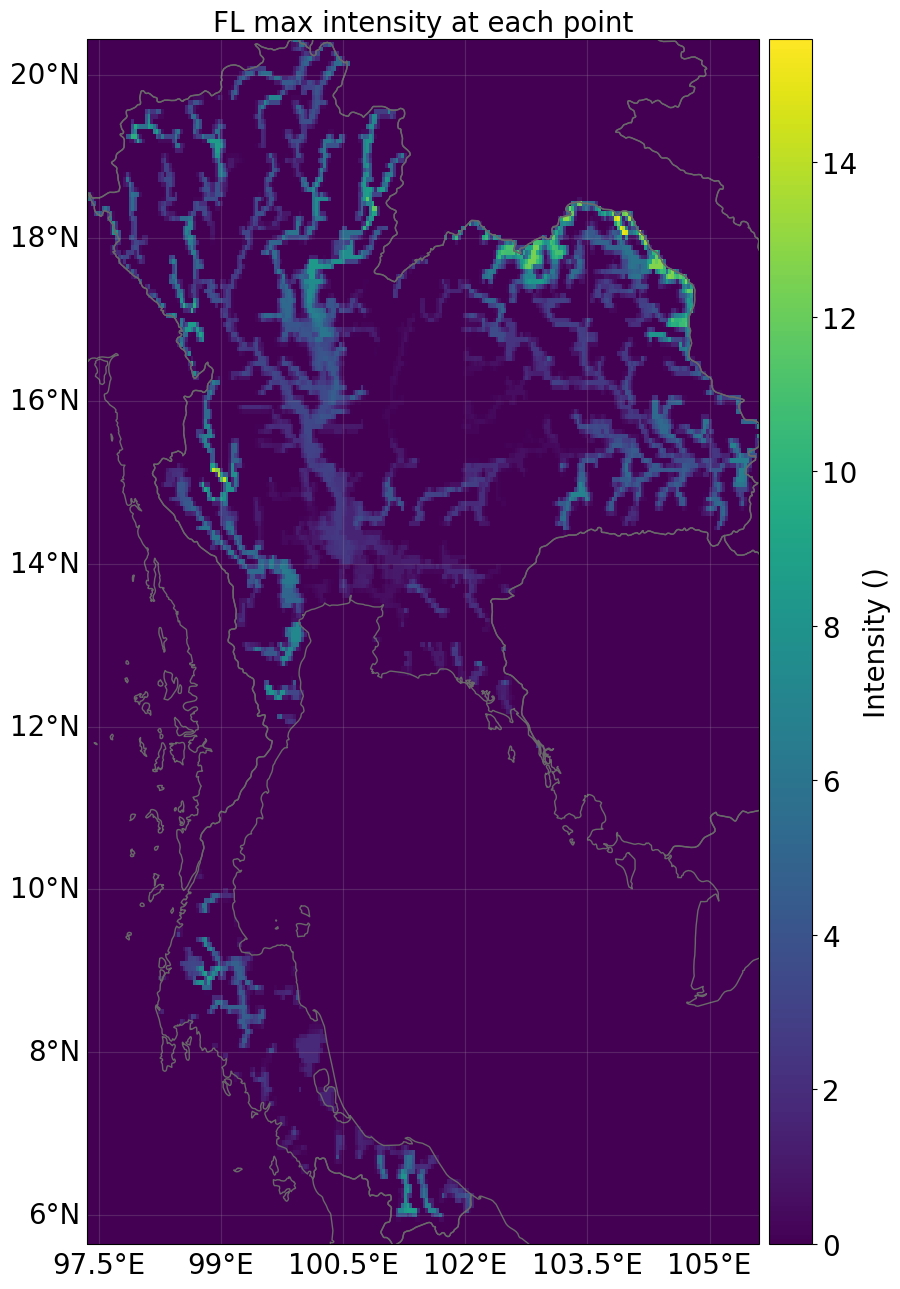

In [30]:
haz.plot_intensity(0)

In [ ]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "exposures"
]
hazard_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "hazard"
]

print(
    f"Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}")

In [ ]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        "country_name": country_name,
    }
)

exposure_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "exposures"
        ]
    )
)
hazard_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "hazard"
        ]
    )
)

print(
    f"Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}")

In [ ]:
# Available climate scenarios and time horizons for specific hazard type in countries Thailand and Egypt
if hazard_type == "river_flood" or "wildfire":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "tropical_cyclone":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties.get("ref_year")
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "earthquake":
    available_scenarios = []
    available_time_horizons = []
if hazard_type == "flood":
    available_scenarios = []
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )

print(
    f"Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}"
)
print(
    f"Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}"
)

In [ ]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        "data_type": "river_flood",
        "country_name": "Thailand",
        "climate_scenario": "rcp26",
        "year_range": "2030_2050",
    }
)
hazard_dataset_infos

In [ ]:
# Get Exposure
# Available Exposures: ['litpop']
exposure_present = exposure_handler.get_exposure(country_name)
if annual_growth > 1:
    exposure_future = exposure_handler.get_growth_exposure(
        exposure_present, annual_growth, 2040)

In [ ]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']
hazard_present = hazard_handler.get_hazard(
    hazard_type,
    "historical",
    "1980_2000",
    country_name,
)

if scenario != "historical":
    hazard_future = hazard_handler.get_hazard(
        hazard_type,
        scenario,
        time_horizon,
        country_name,
    )

In [ ]:
# Get Impact
impact_function_set = impact_handler.calculate_impact_function_set(hazard_present)
impact_present = impact_handler.calculate_impact(exposure_present, hazard_present, impact_function_set)

if scenario != "historical":
    if annual_growth > 1:
        impact_future = impact_handler.calculate_impact(
            exposure_future, hazard_future, impact_function_set)
    impact_future = impact_handler.calculate_impact(
        exposure_present, hazard_future, impact_function_set)

In [ ]:
measure_set = costben_handler.get_measure_set_from_excel('RF')
discount_rates = costben_handler.get_discount_rates_from_excel()

In [ ]:
import pandas as pd
import sqlite3

class DataFrameSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def save_dataframe(self, df, table_name):
        """
        Save a DataFrame to the SQLite database.
        
        :param df: DataFrame to save.
        :param table_name: Name of the table to save the DataFrame to.
        """
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists='replace', index=False)
            print(f"DataFrame saved to {table_name} table.")

    def read_dataframe(self, table_name):
        """
        Read a DataFrame from the SQLite database.
        
        :param table_name: Name of the table to read the DataFrame from.
        :return: DataFrame read from the database.
        """
        with sqlite3.connect(self.db_path) as conn:
            df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
        return df

# Example usage
db_path = 'my_data.db'  # Path to your SQLite database file
df_sqlite = DataFrameSQLite(db_path)

# Assuming you have a DataFrame `df` to save
df_sqlite.save_dataframe(exp_gdf, 'exposure')

# To read the saved DataFrame from the database
df_read = df_sqlite.read_dataframe('exposure')
print(df_read)


In [ ]:
import pandas as pd
import sqlite3


class ExcelToSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def read_excel_to_df(self, excel_path, sheet_name):
        """Reads a specified sheet from an Excel file into a DataFrame."""
        return pd.read_excel(excel_path, sheet_name=sheet_name)

    def adjust_df_columns(self, df, columns_to_keep=None):
        """Adjusts DataFrame columns based on the provided list. If None, keeps all columns."""
        if columns_to_keep is not None:
            df = df[columns_to_keep]
        return df

    def save_df_to_sqlite(self, df, table_name):
        """Saves a DataFrame to an SQLite table, appending data if the table already exists."""
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists="append", index=False)

    def read_table(self, table_name):
        """Reads a table from SQLite database into a DataFrame."""
        with sqlite3.connect(self.db_path) as conn:
            return pd.read_sql(f"SELECT * FROM {table_name}", conn)


# Example usage
db_path = "climadera.db"  # Path to your SQLite database file
excel_path = DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_modified.xlsx"  # Path to your Excel file
excel_to_sqlite = ExcelToSQLite(db_path)

# Define the sheets and corresponding table names
sheets_tables = {
    "assets": "exposures",
    "impact_functions": "impact_functions",
    "measures": "measures",
    "discount": "discount_rates",
    "names": "names",
}

# Iterate over sheets and tables, read, adjust (if needed), and save to SQLite
for sheet, table in sheets_tables.items():
    df = excel_to_sqlite.read_excel_to_df(excel_path, sheet)

    # Here you can define which columns to keep for each table if needed, e.g.:
    # if table == 'exposures':
    #     columns_to_keep = ['Column1', 'Column2']
    #     df = excel_to_sqlite.adjust_df_columns(df, columns_to_keep)
    # else:
    #     df = excel_to_sqlite.adjust_df_columns(df)

    excel_to_sqlite.save_df_to_sqlite(df, table)

In [ ]:
import pandas as pd
import sqlite3


class ExcelToSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def read_excel_and_save(self, excel_path, tabs_columns_mapping):
        """
        Read specified tabs from an Excel file and save them to SQLite database.

        :param excel_path: Path to the Excel file.
        :param tabs_columns_mapping: Dict mapping tab names to their columns adjustments.
        """
        with sqlite3.connect(self.db_path) as conn:
            for tab, columns in tabs_columns_mapping.items():
                df = pd.read_excel(excel_path, sheet_name=tab)

                # Adjust columns if specified
                if columns:
                    df = df[columns]

                df.to_sql(tab, conn, if_exists="append", index=False)
                print(f"Data from {tab} tab saved to {tab} table.")

    def read_table(self, table_name):
        """
        Read data from a specified table in the SQLite database.

        :param table_name: Name of the table to read data from.
        :return: DataFrame with the table data.
        """
        with sqlite3.connect(self.db_path) as conn:
            return pd.read_sql(f"SELECT * FROM {table_name}", conn)


# Example usage
db_path = "climadera.db"  # Path to your SQLite database file
excel_path = DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_modified.xlsx"  # Path to your Excel file
tabs_columns_mapping = {
    "assets": None,  # Specify columns as a list if you want to adjust them, or None to include all
    "impact_functions": None,
    "measures": None,
    "discount": None,
    "names": None,
}

excel_to_sqlite = ExcelToSQLite(db_path)
excel_to_sqlite.read_excel_and_save(excel_path, tabs_columns_mapping)

# Reading data from one of the tables
df_assets = excel_to_sqlite.read_table("assets")
print(df_assets)